In [3]:
import mlflow

mlflow_server_uri = "https://champi.heuzef.com"

mlflow.set_tracking_uri(mlflow_server_uri)
mlflow.set_experiment("champi") # Le nom du projet

with mlflow.start_run():
    for epoch, metrics in epochs_data.items():
        mlflow.log_metric("accuracy", metrics["accuracy"], step=epoch)
        mlflow.log_metric("loss", metrics["loss"], step=epoch)
        mlflow.log_metric("val_accuracy", metrics["val_accuracy"], step=epoch)
        mlflow.log_metric("val_loss", metrics["val_loss"], step=epoch)
        mlflow.log_metric("learning_rate", metrics["learning_rate"], step=epoch)
    mlflow.log_param("model", "resnet50_callbacks_5layers_unfreeze")

In [1]:
import json
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define paths to directories
train_dir = 'C:/Users/vsavelev/GITHUB/DS_projet/LAYER2/MO/train'
validation_dir = 'C:/Users/vsavelev/GITHUB/DS_projet/LAYER2/MO/validation'

# Create Dataset from directories
def create_dataset(directory, batch_size):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=(224, 224),
        batch_size=batch_size,
        label_mode='categorical',  # Labels are one-hot encoded
        shuffle=True
    )
    return dataset

# Load data from directories
batch_size = 32
train_dataset = create_dataset(train_dir, batch_size)
validation_dataset = create_dataset(validation_dir, batch_size)

# Build ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.7)(x)
predictions = Dense(len(train_dataset.class_names), activation='softmax', kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.2,           
    patience=2,           
    min_lr=1e-6           
)

# Custom callback to save metrics per epoch to a JSON file
class MetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_file='resnet50_v3_training_metrics.json'):
        super().__init__()
        self.log_file = log_file
        self.logs = []

    def on_epoch_end(self, epoch, logs=None):
        self.logs.append({
            'epoch': epoch,
            'loss': logs['loss'],
            'accuracy': logs['accuracy'],
            'val_loss': logs['val_loss'],
            'val_accuracy': logs['val_accuracy']
        })
        with open(self.log_file, 'w') as f:
            json.dump(self.logs, f, indent=4)

# Train the model and log metrics
metrics_logger = MetricsLogger(log_file='resnet50_v3_training_metrics.json')

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[reduce_lr, early_stopping, metrics_logger]
)

# Save the model
model.save('resnet50_v3_callbacks.h5')


Found 12616 files belonging to 13 classes.
Found 163 files belonging to 13 classes.
Epoch 1/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 2796s 7s/step - accuracy: 0.0876 - loss: 5.9758 - val_accuracy: 0.3620 - val_loss: 3.9756 - learning_rate: 1.0000e-05
Epoch 2/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 2968s 8s/step - accuracy: 0.1405 - loss: 4.2605 - val_accuracy: 0.5890 - val_loss: 3.6936 - learning_rate: 1.0000e-05
Epoch 3/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 2840s 7s/step - accuracy: 0.2177 - loss: 3.9925 - val_accuracy: 0.6994 - val_loss: 3.2704 - learning_rate: 1.0000e-05
Epoch 4/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 2718s 7s/step - accuracy: 0.3378 - loss: 3.6367 - val_accuracy: 0.7546 - val_loss: 2.7069 - learning_rate: 1.0000e-05
Epoch 5/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 2888s 7s/step - accuracy: 0.4801 - loss: 3.2152 - val_accuracy: 0.7975 - val_loss: 2.3155 - learning_rate: 1.0000e-05
Epoch 6/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 2551s 6s/step - accuracy: 0.6141 - loss: 2.7926 - val_accuracy: 0.7975 - val_loss: 2.2

In [2]:
mlflow_server_uri = "https://champi.heuzef.com"

# check if the server is available

import requests

def is_mlflow_tracking_server_available(mlflow_server_uri):
  try:
    response = requests.get(mlflow_server_uri)
    if response.status_code == 200:
      return True
    else:
      return False
  except requests.exceptions.RequestException:
    return False

if is_mlflow_tracking_server_available(mlflow_server_uri):
  print("Le serveur de tracking MLflow est disponible :", mlflow_server_uri)
else:
  print("Le serveur de tracking MLflow n'est pas disponible.")

requests.get(mlflow_server_uri)

Le serveur de tracking MLflow est disponible : https://champi.heuzef.com


<Response [200]>

In [8]:
import mlflow
import mlflow.tensorflow
from mlflow import MlflowClient
import setuptools

mlflow.set_tracking_uri(mlflow_server_uri)
mlflow.set_experiment("champi") # Le nom du projet
run_name = "resnet50__unfreeze5_callbacks_v3"


ImportError: cannot import name '_REST_CLIENT' from 'mlflow.utils.rest_utils' (c:\Users\vsavelev\AppData\Local\anaconda3\Lib\site-packages\mlflow\utils\rest_utils.py)

In [10]:
import mlflow
import mlflow.keras
import json
import matplotlib.pyplot as plt

# Function to load metrics from JSON
def load_metrics_from_json(log_file='resnet50_v3_training_metrics.json'):
    with open(log_file, 'r') as f:
        return json.load(f)

# Function to plot training history
def plot_training_history(metrics):
    epochs = [m['epoch'] for m in metrics]
    train_accuracy = [m['accuracy'] for m in metrics]
    val_accuracy = [m['val_accuracy'] for m in metrics]
    train_loss = [m['loss'] for m in metrics]
    val_loss = [m['val_loss'] for m in metrics]
    
    plt.figure(figsize=(12, 8))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracy)
    plt.plot(epochs, val_accuracy)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss)
    plt.plot(epochs, val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.savefig("training_history.png")
    plt.show()


# Load metrics and log to MLflow
with mlflow.start_run(run_name=run_name):
    # Load metrics from JSON
    metrics = load_metrics_from_json('resnet50_v3_training_metrics.json')

    # # Log metrics for each epoch
    for m in metrics:
         mlflow.log_metric('train_loss', m['loss'], step=m['epoch'])
         mlflow.log_metric('train_accuracy', m['accuracy'], step=m['epoch'])
         mlflow.log_metric('val_loss', m['val_loss'], step=m['epoch'])
         mlflow.log_metric('val_accuracy', m['val_accuracy'], step=m['epoch'])

    # # Log hyperparameters
    # mlflow.log_param("learning_rate", 1e-5)
    # mlflow.log_param("batch_size", 32)
    # mlflow.log_param("dropout_rate", 0.7)
    # mlflow.log_param("l2_regularization", 0.001)
    
    # mlflow.keras.log_model(model, artifact_path=run_name+"_artifacts")

    #if model is not None:
       # mlflow.keras.log_model(model, "resnet50_v3_training_metri")



MlflowException: API request to https://champi.heuzef.com/api/2.0/mlflow/runs/update failed with exception HTTPSConnectionPool(host='champi.heuzef.com', port=443): Max retries exceeded with url: /api/2.0/mlflow/runs/update (Caused by ReadTimeoutError("HTTPSConnectionPool(host='champi.heuzef.com', port=443): Read timed out. (read timeout=120)"))

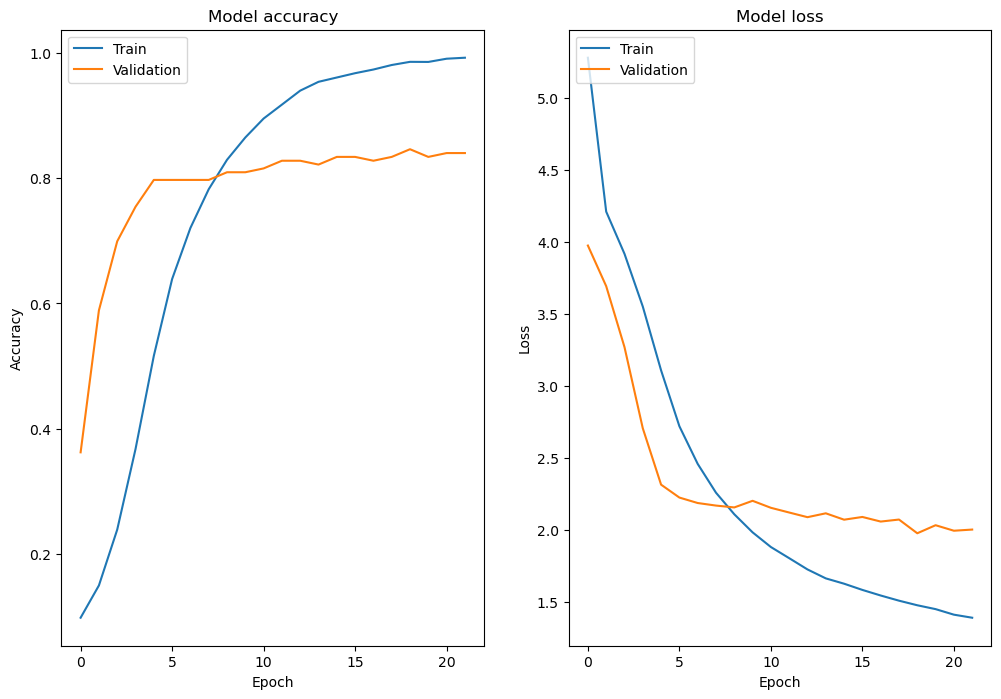

In [5]:

    # Plot and log training history
plot_training_history(metrics)
#mlflow.log_artifact("training_history.png")

    # Log the trained model
    #mlflow.keras.log_model(tf.keras.models.load_model('resnet50_model_callbacks.h5'), "resnet50_model")



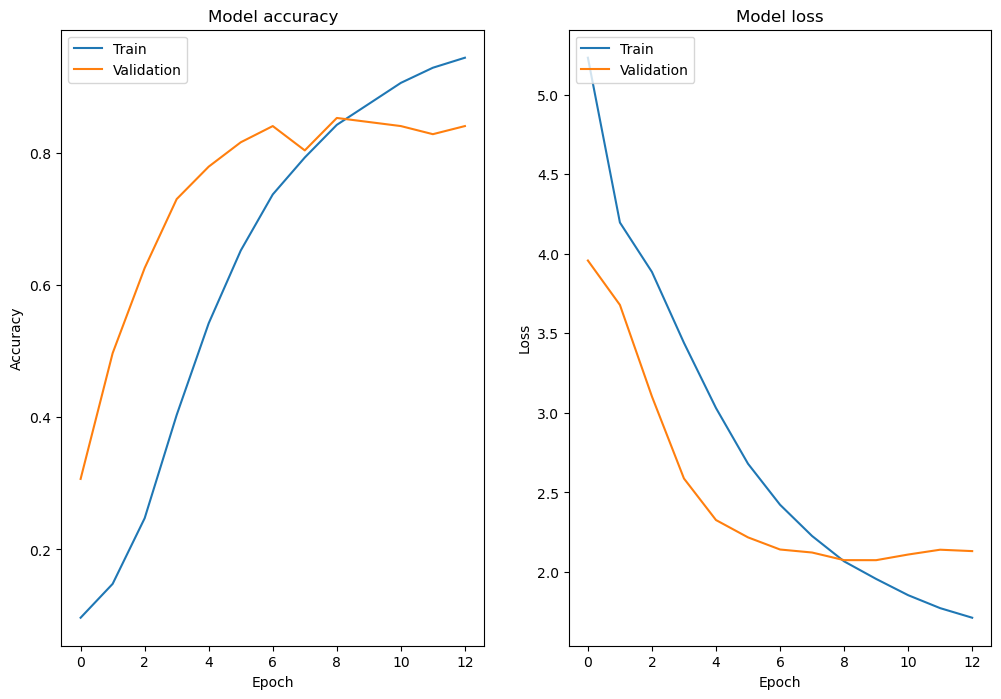

In [7]:
 plot_training_history(metrics)